<a href="https://colab.research.google.com/github/cvillagrasa/EngineeringObjects/blob/main/EngineeringObjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following notebook defines a simple *EngineeringObject* class, which attempts to **bridge the gap** between a **classical engineering** workflow using spreadsheets and more **modern approaches** using **Python**.

Despite having many drawbacks, one of the advantages of the classical approach is that spreadsheets allow for easy formatting. Hence, they encourage to copy tables (either input data or results) directly to technical reports, which makes them convenient. This is a straightforward process which many engineers are currently used to. On the other hand, producing usable output from a Python script or notebook can seem difficult at first.

With the *EngineeringObject* class, enriched variables can be used to produce formatted output directly usable in technical reports.These variables include a value, a $\LaTeX$ name, the units in which the value is expressed and a description.

Therefore, **Python, with all its benefits, can be more easily used for engineering calculations**.

Made available under the [Creative Commons license](https://creativecommons.org/licenses/by/4.0/)

More info on why Python is preferrable over classical spreadsheets for engineering:

[https://mclare.blog/posts/why-structural-engineers-use-excel](https://mclare.blog/posts/why-structural-engineers-use-excel)

#Imports

In [1]:
from dataclasses import dataclass, field, fields, _MISSING_TYPE
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [ ]:
# For LaTeX viz within DataFrames (lasts for some minutes)
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

#Auxiliary functions

In [3]:
def df2fig(df, col_width=3., row_height=2/3, font_size=14, 
           header_color='#21588c', row_colors=['#f1f1f2', 'w'], 
           edge_color='#102B44', bbox=[0, 0, 1, 1], header_columns=0, 
           colWidths=False, with_index=False, custom_colors=False, 
           custom_alignments=False, custom_paddings=False, ax=None, **kwargs):
  '''Produces a matplotlib figure from a DataFrame'''
  created = False
  if ax is None:
    created = True
    size = (np.array(df.shape[::-1]) + np.array([0, 1])) * np.array(
        [col_width, row_height])
    fig, ax = plt.subplots(figsize=size)
  ax.axis('off')
  df_ = df.reset_index(level=0) if with_index else df.copy()

  mpl_args = {
    'cellText': df_.values, 
    'bbox': bbox, 
    'colLabels': df_.columns, 
    'rowLoc': 'center', 
    'colLoc': 'center', 
    'cellLoc':'center'
  }
  
  if colWidths:
    mpl_args.update({'colWidths': colWidths})
  
  mpl_table = ax.table(**mpl_args, **kwargs)
  mpl_table.auto_set_font_size(False)
  mpl_table.set_fontsize(font_size)

  for k, cell in mpl_table._cells.items():
    cell.set_edgecolor(edge_color)
    if k[0] == 0 or k[1] < header_columns:
      cell.set_text_props(fontweight=1000, fontsize=17, color='w')
      cell.set_facecolor(header_color)
    else:
      cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    if custom_alignments:
      if k[1] in custom_alignments.keys():
        cell._loc = custom_alignments[k[1]]
    if custom_paddings:
      if k[1] in custom_paddings.keys():
        cell.PAD = custom_paddings[k[1]]  
  if custom_colors: #usage -> custom_colors={(i, j): '#33d443'
    for cell, color in custom_colors.items():
      mpl_table._cells[(*cell,)].set_facecolor(color)

  if created:
    plt.close()
    return fig
  else:
    return ax.get_figure()

def dfs2fig(dfs, col_width=2., row_height=2/3, padding=2., **kwargs):
  '''Produces a multicolumn matplotlib figure from a list DataFrame list'''
  size = (np.array(dfs[0].shape[::-1]) + np.array([0, 1])) * np.array(
      [col_width, row_height])
  size[0] = len(dfs) * size[0] + (len(dfs) - 1) * padding
  fig, axes = plt.subplots(1, len(dfs), figsize=size)
  for idx, df in enumerate(dfs):
    df2fig(df, ax=axes[idx])
  axes[-1].set_aspect(axes[0].bbox.height / axes[0].bbox.width * 
                      dfs[-1].shape[0] / dfs[0].shape[0], anchor='N')
  plt.close()
  return fig

#Engineering Objects

In [4]:
@dataclass
class DefaultValue:
  value: any

  def __repr__(self):
    return self.value.__repr__()

@dataclass
class EnrichedDefaultAttribute:
  def __post_init__(self):
    for field in fields(self):
      field_value = getattr(self, field.name)
      default, factory = False, False
      if isinstance(field.default, DefaultValue) or (
        isinstance(field.default, EnrichedVariable)):
        default = True
      elif not isinstance(field.default_factory, _MISSING_TYPE):
        if isinstance(field.default_factory(), DefaultValue) or (
        isinstance(field.default_factory(), EnrichedVariable)):
          factory = True
      if default or factory:
        enriched_value = field.default_factory().value if factory else (
            field.default.value)
        if not isinstance(field_value, DefaultValue) and (
            not (isinstance(field.default, _MISSING_TYPE) and
                 isinstance(field.default_factory, _MISSING_TYPE))):
          enriched_value.value = field_value
          setattr(self, field.name, enriched_value)
        field_value = getattr(self, field.name)
        if isinstance(field_value, DefaultValue):
          setattr(self, field.name, enriched_value)

@dataclass
class EnrichedVariable:
  value: any
  units: str
  description: str
  latex: str = ''

@dataclass
class EnrichedFloat(EnrichedVariable):
  value: np.float64
  precision: np.int16 = 0

  def __repr__(self):
    return (
        self.description + ': ' + f'{self.value:0,.{self.precision}f}' + ' ' + 
        self.units
    )

@dataclass
class EnrichedString(EnrichedVariable):
  value: str

  def __repr__(self):
    return (self.description + ': ' + self.value)      

In [5]:
class EngineeringObject(EnrichedDefaultAttribute):
  def __getitem__(self, item):
    item = EnrichedDefaultAttribute.__getattribute__(self, item).value
    return item.value if hasattr(item, 'value') else item
  
  def __setattr__(self, name, value):    
    if name not in self.__dict__.keys():
      super().__setattr__(name, value)
    else:
      curr_attr = getattr(self, name)
      if isinstance(curr_attr, EnrichedVariable):
        curr_attr.value = value
        super().__setattr__(name, curr_attr)
      else:
        super().__setattr__(name, value)
  
  @property
  def df(self):
    params, units, values, desc = [[] for i in range(4)]
    for field in fields(self):
      if isinstance(getattr(self, field.name), EnrichedVariable):
        enriched_value = getattr(self, field.name)
        params.append(f'$${enriched_value.latex}$$')
        units.append(f'$${enriched_value.units}$$')
        if isinstance(enriched_value.value, str):
          values.append(enriched_value.value)          
        else:
          values.append(f'{enriched_value.value:0,.{enriched_value.precision}f}')
        desc.append(enriched_value.description)

    return pd.DataFrame({
        'Parameter': params,
        'Units': units,
        'Value': values,
        'Description': desc
    })
  
  def print(self, **kwargs):
    return df2fig(self.df, colWidths=[0.135, 0.135, 0.11, 0.9], 
                  custom_alignments={3: 'left'}, custom_paddings={3: .04}, 
                  **kwargs)

In [6]:
def def_float(*args, **kwargs):
  return DefaultValue(EnrichedFloat(*args, **kwargs))

def def_string(*args, **kwargs):
  return DefaultValue(EnrichedString(*args, **kwargs))

def df_float(*args, **kwargs):
  return field(default_factory=lambda: def_float(*args, **kwargs))

def df_string(*args, **kwargs):
  return field(default_factory=lambda: def_string(*args, **kwargs))

#Example of usage

In [14]:
@dataclass
class BeamCrossSection(EngineeringObject):
  w: EnrichedFloat = df_float(0, 'm', 'Width', 'w', 3)
  h: EnrichedFloat = df_float(0, 'm', 'Height', 'h', 3)
  i22: EnrichedFloat = df_float(0, 'm^4', 'Moment of inertia (y axis)', 'I_{22}', 6)
  i33: EnrichedFloat = df_float(0, 'm^4', 'Moment of inertia (x axis)', 'I_{33}', 6)
  M2: EnrichedFloat = df_float(0, 'kNm', 'Bending moment (x axis)', 'M_2')
  M3: EnrichedFloat = df_float(0, 'kNm', 'Bending moment (y axis)', 'M_3')
  max_tension_x: EnrichedFloat = df_float(-1, 'MPa', 'Maximum tension (x axis)', '\sigma_{x, max}')
  max_tension_y: EnrichedFloat = df_float(-1, 'MPa', 'Maximum tension (y axis)', '\sigma_{y, max}')

  def __post_init__(self):
    super().__post_init__()
    self.max_tension_x = self.get_max_tension_x()
    self.max_tension_y = self.get_max_tension_y()

  def get_max_tension_x(self):
    return self['M2'] / self['i22'] * self['w'] / 2 / 10 ** 3

  def get_max_tension_y(self):
    return self['M3'] / self['i33'] * self['h'] / 2 / 10 ** 3



In [15]:
one_beam = BeamCrossSection(w=0.4, h=0.75, i22=0.0001, i33=0.0001, M2=100, M3=100)

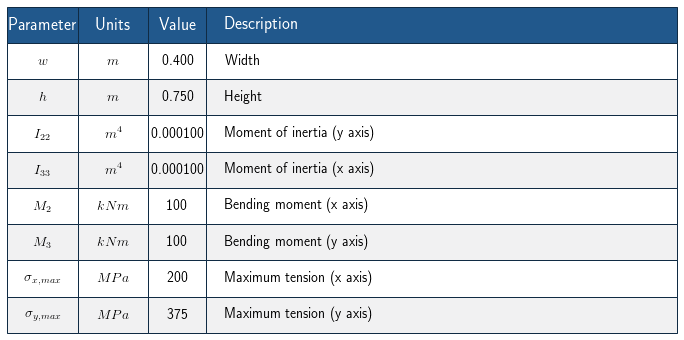

In [16]:
one_beam.print()